# Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wri/cities-urbanshift/blob/indicators-amenity-exposure/baseline-indicators/compute-exposure-amenity-lst.ipynb)


- Author: Saif Shabou
- Contact: Saif.Shabou@wri.org
- Last Edit: August 23, 2021

## Objective
The goal of this script consists of computing indicators for assessing amenities' exposure to extreme heat events based on Land Surface Temperature data. 






## Methodology


![alt text](https://drive.google.com/uc?id=1z7AQ1QLsiBCF2DTicu-p54yfk5KNvrHQ)


### Datasets


| Dataset | Data integration scripts | Data description | Data storage path | Format | Data exploration |
| ------ |------ |------ |------ | ------ | ------ | 
| Administrative boundaries | | [GeoLayers.Administrative boundaries](https://github.com/wri/cities-urbanshift/wiki/GeoLayers.Administrative-boundaries) |  [download from GCS](https://storage.googleapis.com/urbanshift/administrative_boundaries/v1/administrative_boundaries_urbanshift_cities.geojson) | `geojson` | |
| Amenities | [integrate_amenity_data.ipynb](https://github.com/wri/cities-urbanshift/blob/main/geospatial-layers/scripts/amenity/integrate_amenity_data.ipynb)| [GeoLayers.Amenity](https://github.com/wri/cities-urbanshift/wiki/GeoLayers.Amenity) |  [download from GCS](https://storage.googleapis.com/urbanshift/amenity/amenity_all_cities.geojson) |  `geojson` | |
| Amenities sectors | | [GeoLayers.Amenity](https://github.com/wri/cities-urbanshift/wiki/GeoLayers.Amenity) |  [download from GCS](https://storage.googleapis.com/urbanshift/amenity/param/osm_amenity_sectors.csv) |  `csv` | |
| Land Surface Temperature | [integrate_lst_data.js](https://code.earthengine.google.com/5b00ea20c399c16c41c7c2ea98a08586?accept_repo=users%2Femackres%2FSCIP)| [GeoLayers.Land Surface Temperature](https://github.com/wri/cities-urbanshift/wiki/GeoLayers.Land-Surface-Temperature) |  [download from GCS](https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mendoza.tif) |  `GeoTIFF` | |

### Indicators

- **Land Surface Temperature (LST) estimation**: Compute the average Land Surface Temperature within cities' boundaries based on Land Surface Temperature estimation script provided by `Sofia L. Ermida` based on the following parameters:

``` js
var satellite = 'L8';
var date_start = '2018-03-01';
var date_end = '2021-04-30';
var month_start = 6;
var month_end = 9;
var use_ndvi = true;
```

- **Amenity exposure to LST hazards**: Identify amenities exposed to high LST values. Two methods have been explored for specifying *hig LST values*: 
  - Based on a fixed threshold value regradless of LST values distribution within a city (for instance, $LST_Threshold = 30$)
  - Based on LST values distribution within a city (for instance, amenities with LST values higher than median value)

- **Aggregate amenity exposure at city level**: Compute amenity exposure index by city based on the percent of exposed amenities compared to total amenities.

    $$AmenityExposure_{city}= \frac{nb Exposed Amenities_{city}}{Total Amenities_{city}}$$

  where: 
  - $nb Exposed Amenities$ corresponds to the number of amenities located in an area with $LST_{amenity} > LST_{Threshold}$  
  - $nb Total Amenities$ corresponds to the total number of amenities located within the city boundaries

- **Aggregate amenity exposure by sector**: Compute amenity exposure index by city*sector by counting the percent of amenities exposed to LST values higher than the median value.

    $$AmenityExposure_{sector}= \frac{nb Exposed Amenities_{sector}}{Total Amenities_{sector}}$$

  where: 
  - $nb Exposed Amenities_{sector}$ corresponds to the number of amenities belonging to a specific sector located in an area with $LST_{amenity} > median(LST_{amenity})$  
  - $nb Total Amenities$ corresponds to the total number of amenities belonging to a specific sector located within the city boundaries




### Ouputs

| Datasset | Description | Format | Storage link | 
| ---- |---- |---- |---- |
| city_geo_indicators | Storage of number of exposed amenities to LST hazardsby city  | geojson | [GCS download](https://storage.googleapis.com/urbanshift/city_baseline_indicators.geojson) |
| amenity_sector_exposure | Stoage of number of exposed amenities by sector category  | csv | [GCS download](https://storage.googleapis.com/urbanshift/amenity_sector_exposure.csv)|


## Limitations & Perspectives

- **Amenity data coverage:** In this analysis we used amenity deata provided by Open Street Map API. Since the data is not complete and may differ between cities, our results are biased by data coverage. More efforts are then needed for evaluating data coverage and integratin other datasources such as [Google Places API](https://developers.google.com/maps/documentation/places/web-service/overview) or [Google Open Buildings dataset](https://sites.research.google/open-buildings/).

- **Definition of LST hazards**

- **Amenity classification by sector**

---



# Code source





In [2]:
! pip install rasterio #geemap #geopandas #rasterio rioxarray earthpy

     |████████████████████████████████| 19.3 MB 1.4 MB/s 


In [3]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import storage
import json
import rasterio 
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import pandas as pd
import branca.colormap as cm
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [4]:
# specify color palettes for plots
BoldRiverBlue =  '#242456'
BoldSunYellow =  '#FFD450'
BoldGrassGreen =  '#2A553E'
BoldEarthGrey =  '#7B7A66'
BoldBrickOrange =  '#F26640'
LightRiverBlue =  '#E3E6FF'
LightSunYellow =  '#FFEDBA'
LightGrassGreen =  '#C4F4D5'
LightEarthGrey =  '#ECE2D6'
LightBrickOrange =  '#FED3CF'
White = '#FFFFFF'
Black = '#000000'

# Load input data

## Load Administrative boundaries

In [5]:
#admin_boundaries_allCities = gpd.read_file('https://storage.googleapis.com/urbanshift/administrative_boundaries/administrative_boundaries_allCities.geojson')
admin_boundaries_urbanshift_cities = gpd.read_file('https://storage.googleapis.com/urbanshift/administrative_boundaries/v1/administrative_boundaries_urbanshift_cities.geojson')


In [6]:
admin_boundaries_urbanshift_cities.head()

,country_iso,id,name,shapeGroup,shapeID,shapeISO,shapeName,shapeType,ADM0_shape,ADM1_sha_1,ADM1_shape,ADMHIERARC,geometry
0,ARG,ARG-Mendoza,Mendoza,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-70.09376 -33.05128, -70.09369..."
1,ARG,ARG-Mar_del_Plata,Mar del Plata,ARG,ARG-ADM2-1590546715-B389,ARG,Partido de General Pueyrred�n,ADM2,None,None,None,None,"MULTIPOLYGON (((-58.04728 -37.95562, -58.04717..."
2,ARG,ARG-Ushuaia,Ushuaia,ARG,ARG-ADM2-1590546715-B99,ARG,Departamento Ushuaia,ADM2,None,None,None,None,"MULTIPOLYGON (((-64.35062 -54.84401, -64.35014..."
3,ARG,ARG-Salta,Salta,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-65.53171 -25.02690, -65.53166..."
4,ARG,ARG-Buenos_Aires,Buenos Aires,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-58.36618 -34.59744, -58.36609..."


In [7]:
# filter freetown because the city-id has changed from freetown_region to freetown_Core
admin_boundaries_urbanshift_cities = admin_boundaries_urbanshift_cities.loc[admin_boundaries_urbanshift_cities['name'] != 'Freetown Core']
admin_boundaries_urbanshift_cities = admin_boundaries_urbanshift_cities.reset_index(drop=True)

In [8]:
# add centroid coordinates
admin_boundaries_urbanshift_cities["centroid_x"] = admin_boundaries_urbanshift_cities.centroid.x
admin_boundaries_urbanshift_cities["centroid_y"] = admin_boundaries_urbanshift_cities.centroid.y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [9]:
############################### plot a map of geoboundaries

# define map center coordinates
map_center_x = admin_boundaries_urbanshift_cities.centroid_x.mean()
map_center_y = admin_boundaries_urbanshift_cities.centroid_y.mean()

# plot map background
m = folium.Map()
m = folium.Map(location = [map_center_x,map_center_y],zoom_start=2)

# plot adminisrative boundaries
folium.GeoJson(
    admin_boundaries_urbanshift_cities,
    tooltip=folium.features.GeoJsonTooltip(fields=['country_iso','name'],
            aliases=['Country','City name'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )
).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

## Load Amenity data

In [55]:
# get amenity data
amenity_urbanshift_cities = gpd.read_file('https://storage.googleapis.com/urbanshift/amenity/amenity_all_cities.geojson')
amenity_urbanshift_cities.head()

,cityName,featureCategory,featureType,id,integrationDate,latitude,longitude,objectType,projectName,geometry
0,Mendoza,amenity,fuel,272174284,2021-08-03,-33.005630,-68.867760,amenity,urbanshift,POINT (-68.86776 -33.00563)
1,Mendoza,amenity,fuel,272174301,2021-08-03,-32.938090,-68.840430,amenity,urbanshift,POINT (-68.84043 -32.93809)
2,Mendoza,amenity,fuel,272174306,2021-08-03,-32.940225,-68.847488,amenity,urbanshift,POINT (-68.84749 -32.94023)
3,Mendoza,amenity,fuel,272174310,2021-08-03,-32.930245,-68.850123,amenity,urbanshift,POINT (-68.85012 -32.93024)
4,Mendoza,amenity,fuel,272174325,2021-08-03,-33.209606,-68.882347,amenity,urbanshift,POINT (-68.88235 -33.20961)


In [ ]:
# select amenities with frequent records
#df = amenity_urbanshift_cities.groupby(['featureType']).size().reset_index(name='counts').loc[lambda x: x['counts'] > 10].reset_index()
#df.head()

In [11]:
# get amenity sectors
amenity_sectors=pd.read_csv("https://storage.googleapis.com/urbanshift/amenity/param/osm_amenity_sectors.csv")
amenity_sectors.head()

,sector_name,feature_key,feature_value,feature_category
0,Commercial,building,\tretail,Commercial
1,Commercial,building,\twarehouse,Commercial
2,Commercial,building,commercial,Commercial
3,Commercial,building,industrial,Commercial
4,Commercial,amenity,marketplace,Others


In [ ]:
amenity_sectors.sector_name.unique()

array(['Commercial', 'Education', 'Entertainment_Art_Culture',
       'Facilities', 'Financial', 'Healthcare', 'Accommodation', 'Others',
       'Public_Service', 'Sustenance', 'Transportation',
       'Waste_Management', 'industrial', 'agriculture'], dtype=object)

In [56]:
# join amenity loaction with sector names
amenity_urbanshift_cities = amenity_urbanshift_cities.merge(amenity_sectors, 
                                     left_on='featureType',
                                     right_on='feature_value',
                                     how = "left")
amenity_urbanshift_cities['sector_name'] = amenity_urbanshift_cities['sector_name'].replace(np.nan, 'Others')

In [13]:
amenity_urbanshift_cities.head()

,cityName,featureCategory,featureType,id,integrationDate,latitude,longitude,objectType,projectName,geometry,sector_name,feature_key,feature_value,feature_category
0,Mendoza,amenity,fuel,272174284,2021-08-03,-33.005630,-68.867760,amenity,urbanshift,POINT (-68.86776 -33.00563),Transportation,amenity,fuel,Transportation
1,Mendoza,amenity,fuel,272174301,2021-08-03,-32.938090,-68.840430,amenity,urbanshift,POINT (-68.84043 -32.93809),Transportation,amenity,fuel,Transportation
2,Mendoza,amenity,fuel,272174306,2021-08-03,-32.940225,-68.847488,amenity,urbanshift,POINT (-68.84749 -32.94023),Transportation,amenity,fuel,Transportation
3,Mendoza,amenity,fuel,272174310,2021-08-03,-32.930245,-68.850123,amenity,urbanshift,POINT (-68.85012 -32.93024),Transportation,amenity,fuel,Transportation
4,Mendoza,amenity,fuel,272174325,2021-08-03,-33.209606,-68.882347,amenity,urbanshift,POINT (-68.88235 -33.20961),Transportation,amenity,fuel,Transportation


In [14]:
#######################################################################################################################
#  plot amenity within one city  
#######################################################################################################################

# select city name
city_name = "Marrakech"
# select amenity data for the selectd city
city_amenity =  amenity_urbanshift_cities[amenity_urbanshift_cities.cityName == city_name]
# select boundaries data for the selected city
city_boundaries =  admin_boundaries_urbanshift_cities[admin_boundaries_urbanshift_cities.name == city_name]

# color definition in boundary polygon
style_function_Boundaries = lambda x: {
    'fillColor':LightEarthGrey,
    'color': BoldEarthGrey,
    'weight': 3.5,
    'fillOpacity': 0.3
}


# Plot map background
m = folium.Map(location=[float(city_boundaries["centroid_y"]), float(city_boundaries["centroid_x"])],
               zoom_start = 8)


# plot administrative boundaries of selected city
folium.GeoJson(
    city_boundaries,
    name = "Administrative boundaries",
    style_function=style_function_Boundaries,
).add_to(m)

# plot amenities of the selected city
for i in range(0,len(city_amenity)):
   folium.CircleMarker(
      location=[city_amenity.iloc[i]['latitude'], city_amenity.iloc[i]['longitude']],
      popup=city_amenity.iloc[i]['featureType'],
      radius=2,
      color=BoldRiverBlue,
      fill_color=BoldRiverBlue,
      fill=True,
      name = "amenities",
   ).add_to(m)

folium.LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

## Load Land Surface Temperature data

In [15]:
# seelect city id
city_id = "MAR-Marrakech"
# define path
fpath = "https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-"+city_id+".tif"
# open raster data
city_lst_mean_r = rasterio.open(fpath)
# print infos
print(city_lst_mean_r.profile)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2562, 'height': 2660, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -8.426287196569524,
       0.0, -0.00026949458523585647, 32.08009643730588), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [16]:
# read raster data for the selected city
city_lst_mean = city_lst_mean_r.read(1)
print(city_lst_mean)

[[43.63953108 43.93696215 44.17213527 ... 46.20068269 46.25391774
  46.23639977]
 [43.73852481 44.06231854 44.33321897 ... 46.13577249 46.22124772
  46.21560731]
 [43.87244166 44.2277132  44.53508069 ... 46.07295569 46.19749027
  46.22963386]
 ...
 [45.59114483 45.59213808 45.5833686  ... 35.68910786 35.71849576
  35.3626231 ]
 [45.54037289 45.48915776 45.43148359 ... 35.66904148 35.60573999
  35.07246477]
 [45.44824837 45.35731452 45.26192604 ... 35.44455727 35.23199506
  34.49155898]]


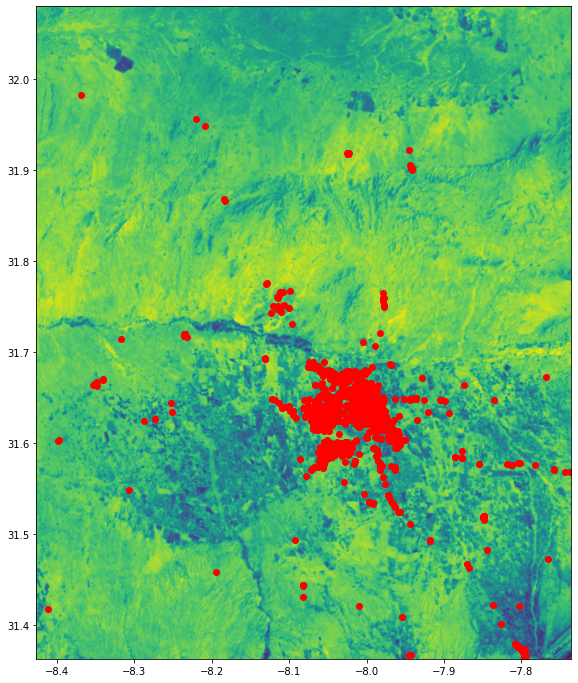

In [17]:
# plot raster data with amenities
fig, ax = plt.subplots(figsize=(12, 12))
rasterio.plot.show(city_lst_mean_r, ax=ax)
city_amenity.plot(ax=ax, facecolor='r', edgecolor='r')

## Extract LST values for amanity location

In [18]:
# get amenity coordinates
city_amenity_coords = [(x,y) for x, y in zip(city_amenity.longitude, city_amenity.latitude)]
# extract lst values for amaenity coordinates
city_amenity['lstMean'] = [x[0] for x in city_lst_mean_r.sample(city_amenity_coords)]

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
city_amenity.lstMean.describe()

count    1762.000000
mean       40.632351
std         1.749868
min        33.519362
25%        39.498998
50%        40.236830
75%        41.434810
max        49.956750
Name: lstMean, dtype: float64

In [20]:
#######################################################################################################################
# plot amenity exposure to LST within one city  
#######################################################################################################################

fig = px.scatter_mapbox(city_amenity, lat="latitude", lon="longitude", hover_name="featureType", hover_data=["lstMean", "cityName"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300, color = "lstMean")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Compute amenity exposure indicator (amenity level)

## Compute exposure by amenity

In [57]:
# join amenity loaction with administrative boundaries data to get city_id filed
amenity_urbanshift_cities = amenity_urbanshift_cities.merge(admin_boundaries_urbanshift_cities[["country_iso", "id","name"]], 
                                     left_on='cityName',
                                     right_on='name',
                                     how = "left")


In [59]:
# map data with the new schema
amenity_urbanshift_cities = (amenity_urbanshift_cities
      .filter(['cityName', 'feature_key','feature_value','feature_category','latitude','longitude','geometry','country_iso','id_y','sector_name'])
      .rename(columns={'cityName': 'city_name', 
                       'id_y': 'city_id'})
)


In [61]:
# create empty dataframe
amenity_exposure = pd.DataFrame(columns=['city_name',
                                           'feature_key',
                                           'feature_value',
                                           'feature_category',
                                           'latitude',
                                           'longitude',
                                           'geometry',
                                           'country_iso',
                                           'city_id',
                                         'sector_name',
                                           'exposure_lst_mean'])

# loop on cities and extract lst values for each amenity feature

for i in range(len(admin_boundaries_urbanshift_cities)):
  city_id = admin_boundaries_urbanshift_cities.loc[i, 'id']
  print("\n City Id: "+city_id)
  # select amenity data for the selectd city
  city_amenity =  amenity_urbanshift_cities[amenity_urbanshift_cities.city_id == city_id]
  # select LST data
  fpath = "https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-"+city_id+".tif"
  print("\n path: "+fpath)
  city_lst_mean_r = rasterio.open(fpath)
  # get amenity coordinates
  city_amenity_coords = [(x,y) for x, y in zip(city_amenity.longitude, city_amenity.latitude)]
  # extract lst values for amenity coordinates
  city_amenity['exposure_lst_mean'] = [x[0] for x in city_lst_mean_r.sample(city_amenity_coords)]
  # append with intiailized dataframe
  amenity_exposure = amenity_exposure.append(city_amenity, ignore_index=True)
  


 City Id: ARG-Mendoza

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mendoza.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: ARG-Mar_del_Plata

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mar_del_Plata.tif

 City Id: ARG-Ushuaia

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Ushuaia.tif

 City Id: ARG-Salta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Salta.tif

 City Id: ARG-Buenos_Aires

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Buenos_Aires.tif

 City Id: BRA-Teresina

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Teresina.tif

 City Id: BRA-Florianopolois

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Florianopolois.tif

 City Id: BRA-Belem

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Belem.tif

 City Id: CRI-San_Jose

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CRI-San_Jose.tif

 City Id: RWA-Kigali

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-RWA-Kigali.tif

 City Id: MAR-M

In [73]:
amenity_exposure.head()

,city_name,feature_key,feature_value,feature_category,latitude,longitude,geometry,country_iso,city_id,sector_name,exposure_lst_mean
0,Mendoza,amenity,fuel,Transportation,-33.005630,-68.867760,POINT (-68.86776 -33.00563),ARG,ARG-Mendoza,Transportation,13.958225
1,Mendoza,amenity,fuel,Transportation,-32.938090,-68.840430,POINT (-68.84043 -32.93809),ARG,ARG-Mendoza,Transportation,22.558078
2,Mendoza,amenity,fuel,Transportation,-32.940225,-68.847488,POINT (-68.84749 -32.94023),ARG,ARG-Mendoza,Transportation,24.450288
3,Mendoza,amenity,fuel,Transportation,-32.930245,-68.850123,POINT (-68.85012 -32.93024),ARG,ARG-Mendoza,Transportation,25.544306
4,Mendoza,amenity,fuel,Transportation,-33.209606,-68.882347,POINT (-68.88235 -33.20961),ARG,ARG-Mendoza,Transportation,16.477196


## Export ouput

In [76]:
# convert into csv
amenity_exposure_csv = amenity_exposure[['city_name',
                                             'feature_key',
                                             'feature_value',
                                             'feature_category',
                                             'latitude',
                                             'longitude',
                                             'country_iso',
                                             'city_id',
                                             'sector_name',
                                             'exposure_lst_mean']].to_csv()

In [77]:
# instatiate a google storage client and specify reauired bucket and file
storgae_client = storage.Client("wri-gee")
bucket = storgae_client.get_bucket('urbanshift')
# define path for writing data
blobName = 'indicators/amenity_exposure/amenity_exposure_lst.csv'

# Create a new blob and upload the file's content.
blob = bucket.blob(blobName)
blob.upload_from_string(amenity_exposure_csv)

# Compute amenity exposure (city level)

## Function developement

In [ ]:
def compute_amenity_exposure_to_LST(administrative_boundaries_gdf, 
                                    amenity_gdf,
                                    lst_mean_threshold):
  """ Compute amenity exposure to land surface temperature 
 
        inputs:
         administrative_boundaries_gdf (geodataframe): The administrative boundaries of cities
         amenity_gdf (geodataframe): The location of amenities within cities
         lst_mean_threshold (float): Temperature threshold above it an amenity is considered exposed to lst hazard
    
        Returns:
         city_geo_indicators (geodataframe): geopandas dataframe containing indicators of cities' amenities exposure to lst hazards
 
    """
  print("\n create empty dataframe")
  city_geo_indicators = administrative_boundaries_gdf[["id","name","geometry"]]
  print("\n loop on cities")
  for i in range(len(city_geo_indicators)):
    cityId = city_geo_indicators.loc[i, 'id']
    cityName = city_geo_indicators.loc[i, 'name']
    print("\n City Id: "+cityId)
    # select amenity data for the selectd city
    city_amenity =  amenity_gdf[amenity_gdf.cityName == cityName]
    # select boundaries data for the selected city
    city_boundaries =  administrative_boundaries_gdf[administrative_boundaries_gdf.name == cityName]
    # select LST data
    fpath = "https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-"+cityId+".tif"
    print("\n path: "+fpath)
    city_lst_mean_r = rasterio.open(fpath)
    # get amenity coordinates
    city_amenity_coords = [(x,y) for x, y in zip(city_amenity.longitude, city_amenity.latitude)]
    # extract lst values for amenity coordinates
    city_amenity['lstMean'] = [x[0] for x in city_lst_mean_r.sample(city_amenity_coords)]
    # compute number of amenities exposed to temperature above and under threshold
    city_amenity_exposure = (city_amenity 
                            .groupby("cityName")
                            .agg(nbAmenityExposed=pd.NamedAgg(column='lstMean', aggfunc=lambda x: (x > lst_mean_threshold).sum()), 
                                nbAmenityNotExposed=pd.NamedAgg(column='lstMean', aggfunc=lambda x: (x < lst_mean_threshold).sum()))
                            .reset_index()
                            )
    print("\n city_amenity_exposure: ")
    print(city_amenity_exposure)
    print("\n successifully computed indicator for: "+cityId)
    city_geo_indicators.loc[i, 'nbAmenityExposed'] = city_amenity_exposure.nbAmenityExposed.values[0]
    city_geo_indicators.loc[i, 'nbAmenityNotExposed'] = city_amenity_exposure.nbAmenityNotExposed.values[0]
    # compute percent of exposed amenities
    city_geo_indicators['percentAmenityExposed'] = round(city_geo_indicators['nbAmenityExposed']/(city_geo_indicators['nbAmenityExposed'] + city_geo_indicators['nbAmenityNotExposed']),2)
  

  return city_geo_indicators 

In [ ]:
# Function implementation through UrbanShift cities
city_geo_indicators = compute_amenity_exposure_to_LST(administrative_boundaries_gdf = admin_boundaries_urbanshift_cities,
                                                      amenity_gdf = amenity_urbanshift_cities,
                                                      lst_mean_threshold = 30)


 create empty dataframe

 loop on cities

 City Id: ARG-Mendoza

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mendoza.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata


 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Mendoza             108.0               3130.0

 successifully computed indicator for: ARG-Mendoza

 City Id: ARG-Mar_del_Plata

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mar_del_Plata.tif

 city_amenity_exposure: 
        cityName  nbAmenityExposed  nbAmenityNotExposed
0  Mar del Plata               0.0                827.0

 successifully computed indicator for: ARG-Mar_del_Plata

 City Id: ARG-Ushuaia

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Ushuaia.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Ushuaia               0.0                272.0

 successifully computed indicator for: ARG-Ushuaia

 City Id: ARG-Salta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Salta.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0    Salta              12.0               1246.0

 successifully computed indicator for: ARG-Salta

 City Id: ARG-Buenos_Aires

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Buenos_Aires.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
       cityName  nbAmenityExposed  nbAmenityNotExposed
0  Buenos Aires              13.0              11775.0

 successifully computed indicator for: ARG-Buenos_Aires

 City Id: BRA-Teresina

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Teresina.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
   cityName  nbAmenityExposed  nbAmenityNotExposed
0  Teresina            1930.0                  1.0

 successifully computed indicator for: BRA-Teresina

 City Id: BRA-Florianopolois

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Florianopolois.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
         cityName  nbAmenityExposed  nbAmenityNotExposed
0  Florianopolois               0.0               2752.0

 successifully computed indicator for: BRA-Florianopolois

 City Id: BRA-Belem

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Belem.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0    Belem            1114.0                  1.0

 successifully computed indicator for: BRA-Belem

 City Id: CRI-San_Jose

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CRI-San_Jose.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
   cityName  nbAmenityExposed  nbAmenityNotExposed
0  San Jose            4854.0               1298.0

 successifully computed indicator for: CRI-San_Jose

 City Id: RWA-Kigali

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-RWA-Kigali.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0   Kigali             453.0                 68.0

 successifully computed indicator for: RWA-Kigali

 City Id: MAR-Marrakech

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-MAR-Marrakech.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
    cityName  nbAmenityExposed  nbAmenityNotExposed
0  Marrakech            1761.0                  0.0

 successifully computed indicator for: MAR-Marrakech

 City Id: IND-Chennai

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Chennai.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Chennai            6468.0                 47.0

 successifully computed indicator for: IND-Chennai

 City Id: IND-Pune

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Pune.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0     Pune            3901.0                128.0

 successifully computed indicator for: IND-Pune

 City Id: IND-Surat

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Surat.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0    Surat            1660.0                  2.0

 successifully computed indicator for: IND-Surat

 City Id: CHN-Chengdu

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Chengdu.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Chengdu            1717.0                354.0

 successifully computed indicator for: CHN-Chengdu

 City Id: CHN-Chongqing

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Chongqing.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
    cityName  nbAmenityExposed  nbAmenityNotExposed
0  Chongqing            1615.0                345.0

 successifully computed indicator for: CHN-Chongqing

 City Id: CHN-Ningbo

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Ningbo.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0   Ningbo            2304.0                103.0

 successifully computed indicator for: CHN-Ningbo

 City Id: IDN-Jakarta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Jakarta.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Jakarta           10990.0                 27.0

 successifully computed indicator for: IDN-Jakarta

 City Id: IDN-Bitung

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Bitung.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0   Bitung             335.0                 28.0

 successifully computed indicator for: IDN-Bitung

 City Id: IDN-Semarang

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Semarang.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
   cityName  nbAmenityExposed  nbAmenityNotExposed
0  Semarang            2180.0                 27.0

 successifully computed indicator for: IDN-Semarang

 City Id: IDN-Balikpapan

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Balikpapan.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
     cityName  nbAmenityExposed  nbAmenityNotExposed
0  Balikpapan               6.0                 10.0

 successifully computed indicator for: IDN-Balikpapan

 City Id: IDN-Palembang

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Palembang.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
    cityName  nbAmenityExposed  nbAmenityNotExposed
0  Palembang             437.0                 26.0

 successifully computed indicator for: IDN-Palembang


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Export Ouput

### Export to Google Cloud Storage

In [ ]:
# convert into geojson
city_geo_indicators_geojson = city_geo_indicators.to_json()
# instatiate a google storage client and specify reauired bucket and file
storgae_client = storage.Client("wri-gee")
bucket = storgae_client.get_bucket('urbanshift')
# define path for writing data
blobName = 'city_baseline_indicators.geojson'

# Create a new blob and upload the file's content.
blob = bucket.blob(blobName)
blob.upload_from_string(city_geo_indicators_geojson)

## Explore output

In [ ]:
city_geo_indicators = gpd.read_file('https://storage.googleapis.com/urbanshift/city_baseline_indicators.geojson')
display(city_geo_indicators)

,id,name,nbAmenityExposed,nbAmenityNotExposed,percentAmenityExposed,percentAmenityExposedv2,geometry
0,ARG-Mendoza,Mendoza,108.0,3130.0,0.03,0.480705,"MULTIPOLYGON (((-70.09376 -33.05128, -70.09369..."
1,ARG-Mar_del_Plata,Mar del Plata,0.0,827.0,0.00,0.000000,"MULTIPOLYGON (((-58.04728 -37.95562, -58.04717..."
2,ARG-Ushuaia,Ushuaia,0.0,272.0,0.00,0.000000,"MULTIPOLYGON (((-64.35062 -54.84401, -64.35014..."
3,ARG-Salta,Salta,12.0,1246.0,0.01,0.053412,"MULTIPOLYGON (((-65.53171 -25.02690, -65.53166..."
4,ARG-Buenos_Aires,Buenos Aires,13.0,11775.0,0.00,0.057863,"MULTIPOLYGON (((-58.36618 -34.59744, -58.36609..."
5,BRA-Teresina,Teresina,1930.0,1.0,1.00,8.590377,"MULTIPOLYGON (((-42.59900 -5.35000, -42.60100 ..."
6,BRA-Florianopolois,Florianopolois,0.0,2752.0,0.00,0.000000,"MULTIPOLYGON (((-48.58167 -27.76205, -48.57442..."
7,BRA-Belem,Belem,1114.0,1.0,1.00,4.958383,"MULTIPOLYGON (((-48.54139 -1.35451, -48.53229 ..."
8,CRI-San_Jose,San Jose,4854.0,1298.0,0.79,21.605021,"MULTIPOLYGON (((-83.76411 9.60486, -83.76250 9..."
9,RWA-Kigali,Kigali,453.0,68.0,0.87,2.016291,"MULTIPOLYGON (((29.97953 -1.88664, 29.98450 -1..."


### Map of cities with amenity exposure level

In [ ]:
geo_df = city_geo_indicators.set_index("name")

fig = px.choropleth_mapbox(geo_df,
                           geojson=geo_df.geometry,
                           locations=geo_df.index,
                           color="percentAmenityExposed",
                           #center={"lat": 45.5517, "lon": -73.7073},
                           mapbox_style="carto-positron", #"open-street-map"
                           color_continuous_scale="Bluered", #https://plotly.com/python/builtin-colorscales/
                           zoom=1,
                           #hover_data=["nbAmenityExposed"],
                           hover_name="id",
                           )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Comparison of city exposure

In [ ]:
fig = px.bar(city_geo_indicators.sort_values(by=['percentAmenityExposed']), x='name', y='percentAmenityExposed')
fig.show()

# Compute amenity exposure by sector 

## Function development

In [ ]:
def compute_amenity_sector_exposure_to_LST(administrative_boundaries_gdf, 
                                    amenity_gdf):
  """ Compute amenity exposure to land surface temperature by sector
 
        inputs:
         administrative_boundaries_gdf (geodataframe): The administrative boundaries of cities
         amenity_gdf (geodataframe): The location of amenities within cities
         lst_mean_threshold (float): Temperature threshold above it an amenity is considered exposed to lst hazard
    
        Returns:
         amenity_sector_exposure (geodataframe): pandas dataframe containing indicators of cities' amenities exposure to lst hazards
 
    """
  # create empty dataframe
  amenity_sector_exposure = pd.DataFrame(columns=['cityName',
                                                     'sector_name',
                                                     'nb_amenity_exposed',
                                                     'nb_amenity_not_exposed',
                                                     'percent_amenity_exposed'])
  # loop on cities
  for i in range(len(administrative_boundaries_gdf)):
    cityId = administrative_boundaries_gdf.loc[i, 'id']
    cityName = administrative_boundaries_gdf.loc[i, 'name']
    print("\n City Id: "+cityId)
    #select amenity data for the selectd city
    city_amenity =  amenity_gdf[amenity_gdf.cityName == cityName]
    # select boundaries data for the selected city
    city_boundaries =  administrative_boundaries_gdf[administrative_boundaries_gdf.name == cityName]
    # select LST data
    fpath = "https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-"+cityId+".tif"
    print("\n path: "+fpath)
    city_lst_mean_r = rasterio.open(fpath)
    # get amenity coordinates
    city_amenity_coords = [(x,y) for x, y in zip(city_amenity.longitude, city_amenity.latitude)]
    # extract lst values for amenity coordinates
    city_amenity['lstMean'] = [x[0] for x in city_lst_mean_r.sample(city_amenity_coords)]
    # compute median LST value
    lst_mean_threshold = city_amenity.lstMean.median()
    # Compute percent of exposed amenities by sector
    city_sector_amenity_exposure = (city_amenity 
                              .groupby(["cityName","sector_name"])
                              .agg(nb_amenity_exposed=pd.NamedAgg(column='lstMean', aggfunc=lambda x: (x > lst_mean_threshold).sum()), 
                                  nb_amenity_not_exposed=pd.NamedAgg(column='lstMean', aggfunc=lambda x: (x < lst_mean_threshold).sum()))
                              .reset_index()
                              )
    city_sector_amenity_exposure['percent_amenity_exposed'] = round(city_sector_amenity_exposure['nb_amenity_exposed']/(city_sector_amenity_exposure['nb_amenity_exposed'] + city_sector_amenity_exposure['nb_amenity_not_exposed']),2)
    # apend to dataframe
    amenity_sector_exposure = amenity_sector_exposure.append(city_sector_amenity_exposure, ignore_index=True)


  return amenity_sector_exposure 


In [ ]:
# Function implementation through UrbanShift cities
amenity_sector_exposure = compute_amenity_sector_exposure_to_LST(administrative_boundaries_gdf = admin_boundaries_urbanshift_cities,
                                                                 amenity_gdf = amenity_urbanshift_cities)


 City Id: ARG-Mendoza

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mendoza.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: ARG-Mar_del_Plata

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mar_del_Plata.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: ARG-Ushuaia

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Ushuaia.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: ARG-Salta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Salta.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: ARG-Buenos_Aires

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Buenos_Aires.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: BRA-Teresina

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Teresina.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: BRA-Florianopolois

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Florianopolois.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: BRA-Belem

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Belem.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: CRI-San_Jose

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CRI-San_Jose.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: RWA-Kigali

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-RWA-Kigali.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: MAR-Marrakech

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-MAR-Marrakech.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IND-Chennai

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Chennai.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IND-Pune

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Pune.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IND-Surat

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Surat.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: CHN-Chengdu

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Chengdu.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: CHN-Chongqing

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Chongqing.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: CHN-Ningbo

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Ningbo.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IDN-Jakarta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Jakarta.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IDN-Bitung

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Bitung.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IDN-Semarang

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Semarang.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IDN-Balikpapan

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Balikpapan.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 City Id: IDN-Palembang

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Palembang.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Export Output

In [ ]:
# convert into csv
amenity_sector_exposure_csv = amenity_sector_exposure.to_csv()

In [ ]:
# instatiate a google storage client and specify reauired bucket and file
storgae_client = storage.Client("wri-gee")
bucket = storgae_client.get_bucket('urbanshift')
# define path for writing data
blobName = 'amenity_sector_exposure.csv'

# Create a new blob and upload the file's content.
blob = bucket.blob(blobName)
blob.upload_from_string(amenity_sector_exposure_csv)

## Explore output

In [ ]:
amenity_sector_exposure = pd.read_csv('https://storage.googleapis.com/urbanshift/amenity_sector_exposure.csv')

In [ ]:
amenity_sector_exposure.head()

,Unnamed: 0,cityName,sector_name,nb_amenity_exposed,nb_amenity_not_exposed,percent_amenity_exposed
0,0,Mendoza,Accommodation,0.0,3.0,0.00
1,1,Mendoza,Commercial,5.0,3.0,0.62
2,2,Mendoza,Education,186.0,252.0,0.42
3,3,Mendoza,Entertainment_Art_Culture,77.0,107.0,0.42
4,4,Mendoza,Facilities,51.0,68.0,0.43


### Sector exposure for one city

In [ ]:
## plot one city
# select a city
cityName = amenity_sector_exposure.cityName.unique().tolist()[1]
amenity_sector_exposure_selected_city = amenity_sector_exposure[amenity_sector_exposure.cityName == cityName]

# plot sector exposure
fig = px.bar(amenity_sector_exposure_selected_city.sort_values(by=['percent_amenity_exposed'], ascending=False), 
             x='sector_name', 
             y='percent_amenity_exposed',
             color_discrete_sequence=[BoldRiverBlue],
             hover_data=['cityName', 'sector_name', "percent_amenity_exposed"],
             hover_name="sector_name",
             labels={'cityName':'City name',
                     'sector_name': 'Sector',
                     'percent_amenity_exposed': 'Percent of exposed amenities'},
             title="Amenity exposure by sectors")
fig.show()

### Sector exposure for all cities

In [ ]:
## plot all cities



# plotly setup
plot_rows=7
plot_cols=3
fig = make_subplots(rows=plot_rows, 
                    cols=plot_cols,
                    shared_xaxes=False,
                    vertical_spacing=0.09,
                    subplot_titles = amenity_sector_exposure.cityName.unique().tolist()[0:21])

# add traces
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        #print(str(i)+ ', ' + str(j))
        # select a city
        cityName = amenity_sector_exposure.cityName.unique().tolist()[x]
        amenity_sector_exposure_selected_city = amenity_sector_exposure[amenity_sector_exposure.cityName == cityName]
        fig.add_trace(go.Bar(x=amenity_sector_exposure_selected_city.sector_name,
                             y=amenity_sector_exposure_selected_city.percent_amenity_exposed,
                             width=[0.7]*14,
                             text=amenity_sector_exposure_selected_city['cityName'],
                             hovertemplate= "<b>%{text}</b><br><br>" + 
                             "Exposed amenity: %{y:.0%}<br>" + "Exposed amenity: %{x:.0%}<br>",
                             name = 'cityName'),
              row=i, col=j)

        x=x+1

# Format and show fig
fig.update_layout(height=2000, width=900,
                  title_text="Percent of exposed amenities by sector",
                  font=dict(size=8),
                  # xaxis={'categoryorder':'total descending'},
                  xaxis={'categoryorder':'array', 'categoryarray':amenity_sector_exposure.sector_name.unique()},
                  showlegend=False)

fig.update_yaxes(range=[0, 1])

fig.show()